In [102]:
img_path = '../resources/raw_imgs/chebu.jpg'
# Resized image from ffmpeg to compare to
blurred_image_path = '../resources/raw_imgs/output.jpg'
# Deviation of Gaussian Blur (can configure vertical/horizontal blurs separately but we won't)
sigma = 10.0
sigmaV = 10.0
# Ignoring the planes option, ffmpeg lets you filter only one color channel at a time
# Can run more steps of the gaussian blur approximation but we will do 1 which is the ffmpeg default
steps = 1





In [103]:
# Load in image
import numpy as np
from PIL import Image

def decompose_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image is RGB
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    # Decompose into R, G, B channels
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    b_channel = img_array[:, :, 2]
    
    
    return r_channel, g_channel, b_channel

# Usage
r, g, b = decompose_image(img_path)
r_blurred, g_blurred, b_blurred = decompose_image(blurred_image_path)

In [104]:
# Compute parameters for function and define context
import math

# Copied from ffmpeg
# Called lambdaParam since lambda is reserved keyword in Python
# Not implementing the case where we can have separate sigma, sigmaV, but this requires squaring postscale
lambdaParam = (sigma * sigma) / (2.0 * steps)
dnu = (1.0 + 2.0 * lambdaParam - math.sqrt(1.0 + 4.0 * lambdaParam)) / (2.0 * lambdaParam)
postscale = pow(dnu / lambdaParam, steps)
boundaryscale = 1.0 / (1.0 - dnu)
nu = float(dnu)

def is_normal(x):
    fmin_normalized = np.finfo(type(x)).tiny
    return math.isfinite(x) and x != 0.0 and abs(x) > fmin_normalized

if not is_normal(postscale):
    print("Not normality triggered!")
    postscale = 1.0
if not is_normal(boundaryscale):
    print("Not normality triggered!")
    boundaryscale = 1.0
if not is_normal(nu):
    print("Not normality triggered!")
    nu = 0.0
    

# static void set_params(float sigma, int steps, float *postscale, float *boundaryscale, float *nu)
# {
#     double dnu, lambda;

#     lambda = (sigma * sigma) / (2.0 * steps);
#     dnu = (1.0 + 2.0 * lambda - sqrt(1.0 + 4.0 * lambda)) / (2.0 * lambda);
#     *postscale = pow(dnu / lambda, steps);
#     *boundaryscale = 1.0 / (1.0 - dnu);
#     *nu = (float)dnu;
#     if (!isnormal(*postscale))
#         *postscale = 1.f;
#     if (!isnormal(*boundaryscale))
#         *boundaryscale = 1.f;
#     if (!isnormal(*nu))
#         *nu = 0.f;
# }

In [105]:
# Define hpass
# static void horiz_slice_c(float *buffer, int width, int height, int steps,
#                           float nu, float bscale, float *localbuf)
# {
#     int x;
#     for (int y = 0; y < height; y++) {
#         for (int step = 0; step < steps; step++) {
#             float *ptr = buffer + width * y;
#             ptr[0] *= bscale;

#             /* Filter rightwards */
#             for (x = 1; x < width; x++)
#                 ptr[x] += nu * ptr[x - 1];
#             ptr[x = width - 1] *= bscale;

#             /* Filter leftwards */
#             for (; x > 0; x--)
#                 ptr[x - 1] += nu * ptr[x];
#         }
#     }
# }


def hpass(channel):
    x = 0
    height, width = channel.shape
    for y in range(0, height):
        for step in range(0, steps):
            row = channel[y]
            row[0] *= boundaryscale
            
            for x in range(1, width):
                row[x] += (nu*row[x-1])
            row[width-1] *= boundaryscale
            
            for x in range(width-1, 0, -1):
                row[x-1] += (nu*row[x])



In [ ]:
# Define vpass
# static void do_vertical_columns(float *buffer, int width, int height,
#                                 int column_begin, int column_end, int steps,
#                                 float nu, float boundaryscale, int column_step)
# {
#     const int numpixels = width * height;
#     int i; 
#     for (int x = column_begin; x < column_end;) {
#         for (int step = 0; step < steps; step++) {
#             float *ptr = buffer + x;
#             for (int k = 0; k < column_step; k++) {
#                 ptr[k] *= boundaryscale;
#             }
#             /* Filter downwards */
#             for (i = width; i < numpixels; i += width) {
#                 for (int k = 0; k < column_step; k++) {
#                     ptr[i + k] += nu * ptr[i - width + k];
#                 }
#             }
#             i = numpixels - width;

#             for (int k = 0; k < column_step; k++)
#                 ptr[i + k] *= boundaryscale;

#             /* Filter upwards */
#             for (; i > 0; i -= width) {
#                 for (int k = 0; k < column_step; k++)
#                     ptr[i - width + k] += nu * ptr[i + k];
#             }
#         }
#         x += column_step;
#     }
# }
# static void verti_slice_c(float *buffer, int width, int height,
#                           int slice_start, int slice_end, int steps,
#                           float nu, float boundaryscale)
# {
#     int aligned_end = slice_start + (((slice_end - slice_start) >> 3) << 3);
#     /* Filter vertically along columns (process 8 columns in each step) */
#     do_vertical_columns(buffer, width, height, slice_start, aligned_end,
#                         steps, nu, boundaryscale, 8);
#     /* Filter un-aligned columns one by one */
#     do_vertical_columns(buffer, width, height, aligned_end, slice_end,
#                         steps, nu, boundaryscale, 1);
# }

# Note: the business with batching columns in groups of 8 is for using cache lines properly. Those don't exist in a ZKVM!
def vpass(channel):
    height, width = channel.shape
    for x in range(0, width):
        for step in range(0, steps):
            column = channel[:, x]
            column[0] *= boundaryscale
            
            for y in range(1, height):
                column[y] += (nu*column[y-1])
            column[height-1] *= boundaryscale
            
            for y in range(height-1, 0, -1):
                column[y-1] += (nu*column[y])
    

In [107]:
# Define postscale
# These are IEEE 754 floats AFAICT and min/max should be the min/max for 32-bit floats
# static void postscale_c(float *buffer, int length,
#                         float postscale, float min, float max)
# {
#     for (int i = 0; i < length; i++) {
#         buffer[i] *= postscale;
#         buffer[i] = av_clipf(buffer[i], min, max);
#     }
# }

def postscalePass(channel):
    # I'm pretty sure float is false here since we're using a pixel format that doesn't use floats for intensity
    # So this is set to 255.
    maxF = 255
    minF = 0
    # Need to scale for sigma and sigmaV
    postscaleFactor = postscale*postscale
    
    rows, cols = channel.shape
    for i in range(rows):
        for j in range(cols):
            channel[i,j] *= postscaleFactor
            # Do rounding here (this occurs in the array copying step with lrintf in the code)
            # But i want it here.
            channel[i,j] = np.rint(min(max(channel[i,j], minF), maxF))
            



In [108]:
# Run the 3 filters for each image plane
r_copy = np.copy(r)
g_copy = np.copy(g)
b_copy = np.copy(b)

image_channels = [r_copy, g_copy, b_copy]

for i in range(0, 3):
    # FFMPEG converts the channel to float32 for calculations
    channel = image_channels[i]
    channel = channel.astype(np.float32)
    hpass(channel)
    vpass(channel)
    postscalePass(channel)
    image_channels[i] = channel.astype(np.uint8)


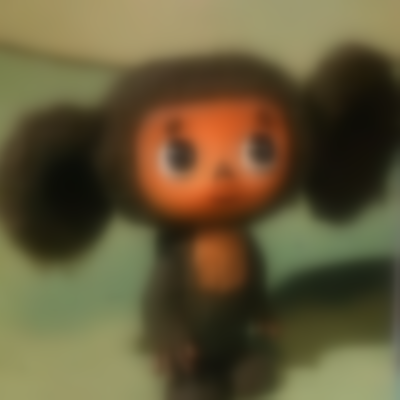

In [109]:
# Define an image recombination function
# Reconstitute from R,G,B channels
def reconstitute_image(r,g,b):
    rgb_array = np.stack((r, g, b), axis=-1).astype(np.uint8)
    image = Image.fromarray(rgb_array, 'RGB')
    # Builtin in jupyter
    display(image)


reconstitute_image(image_channels[0],image_channels[1],image_channels[2])

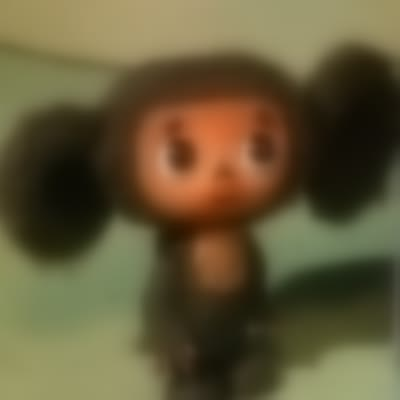

In [110]:
# Compare to output.jpeg?

reconstitute_image(r_blurred, g_blurred, b_blurred)

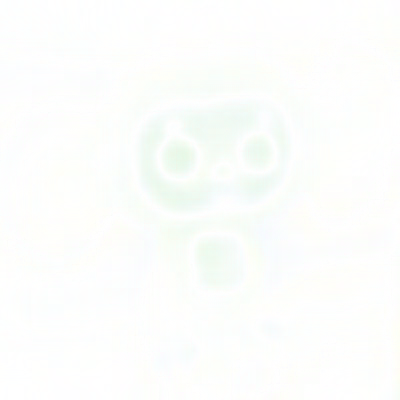

In [111]:
def abs_differences(a, b):
    a_int32 = a.astype(np.int32)
    b_int32 = b.astype(np.int32)
    
    difference = np.abs(a_int32 - b_int32)
    result = np.uint8(np.clip(difference, 0, 255))
    result = 255-result
    return result
    
    
    

r_diff = abs_differences(image_channels[0], r_blurred)
g_diff = abs_differences(image_channels[1], g_blurred)
b_diff = abs_differences(image_channels[2], b_blurred)



reconstitute_image(r_diff, g_diff, b_diff)

In [101]:
np.min(r_diff), np.min(g_diff), np.min(b_diff) 

(np.uint8(243), np.uint8(248), np.uint8(237))